# **Wheat detection using YOLOv5**

## **Cloning repository of YOLOv5**

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10866, done.
remote: Total 10866 (delta 0), reused 0 (delta 0), pack-reused 10866
Receiving objects: 100% (10866/10866), 10.97 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (7508/7508), done.


In [2]:
!python -m pip install --upgrade pip
!pip install -r ./yolov5/requirements.txt

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 KB 12.3 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html

× The package index page being used does not have a proper HTML doctype declaration.
╰─> Problematic URL: https://download.pytorch.org/whl/torch_stable.html

note: This is an issue with the page at the URL mentioned above.
hint: You might need to reach out to the owner of that package index, to get this fixed. See https://github.com/pypa/pip/issues/10825 for context.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 66.3 MB/s eta 0:00:01tcmalloc: large alloc 2041348096 bytes == 0x55d3ac226000 @  0x7f37eb88a1e7 0x55d3a8add5d7 0x55d3a8aa73bc 0x55d3a8b8818a 0x55d3a8aaa1cd 0x55d3a8b9cb3d 0x55d3a8b1e458 0x55d3a8b1902f 0x55d3a8aababa 0x55d3a8b1a108 0x55d3a8b1902f 0x55d3a8aababa 0x55d3a8b1a108 0x55d3a8b1902f 0x55d3a8aababa 0x55d3a8b1a108 0x55d3a8b1902f 0x55d3a8aababa 0x55d3a8b1a108 0x55d3a8b1902f 0x55d3a8aababa 0x55d3a8b1a108 0x55d3a8aab9da 0x55d3a8b1a108 0x55d3a8b1902f 0x55d3a8aababa 0x55d3a8b1acd4 0x55d3a8b1902f 0x

## **Prepare training data to YOLOv5 format**

In [4]:
import numpy as np 
import pandas as pd 
import os
import shutil as sh
from IPython.display import Image
import torch

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0

df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


In [6]:
trainPath = '/content/drive/MyDrive/Colab Notebooks/train'
testPath = "/content/drive/MyDrive/Colab Notebooks/test"
csvPath = "/content/drive/MyDrive/Colab Notebooks/train.csv"

train_ratio = 0.8

totalImgs = list(set(df.image_id))

#counting range for cycles
totalImgs_length = len(totalImgs)
train_data = totalImgs[:int(totalImgs_length*train_ratio)]
val_data = totalImgs[int(totalImgs_length*train_ratio):]
print("training images are : ",len(train_data))
print("Validation images are : ",len(val_data))

training images are :  2698
Validation images are :  675


In [7]:
trainimagePath = '/content/drive/MyDrive/Colab Notebooks/dataset/images/train'
trainlabelPath = '/content/drive/MyDrive/Colab Notebooks/dataset/labels/train'
valimagePath = '/content/drive/MyDrive/Colab Notebooks/dataset/images/val'
vallabelPath = '/content/drive/MyDrive/Colab Notebooks/dataset/labels/val'
for j in [trainimagePath,trainlabelPath,valimagePath,vallabelPath]:
    os.makedirs(j)    

In [8]:
all(True if i[-3:]=="jpg" else False for i in os.listdir(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/train/"))

True

In [9]:
for i in train_data:
    if os.path.exists(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/train/{i}.jpg"):
        sh.copy(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/train/{i}.jpg",f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/dataset/images/train/{i}.jpg")
        with open(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/dataset/labels/train/{i}.txt","w+") as f:
            row = (df.groupby("image_id").get_group(i)[['classes','x_center','y_center','w','h']].astype(float).values/1024).astype(str)
            for j in range(len(row)):
                text = " ".join(row[j])
                f.write(text)
                f.write("\n")
for i in val_data:
    if os.path.exists(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/train/{i}.jpg"):
        sh.copy(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/train/{i}.jpg",f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/dataset/images/val/{i}.jpg")
        with open(f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/dataset/labels/val/{i}.txt","w+") as f:
            row = (df.groupby("image_id").get_group(i)[['classes','x_center','y_center','w','h']].astype(float).values/1024).astype(str)
            for j in range(len(row)):
                text = " ".join(row[j])
                f.write(text)
                f.write("\n")

## **Creation of YAML file for dataset configuration**

In [10]:
s = """
# train and val datasets
train: /content/drive/MyDrive/Colab Notebooks/dataset/images/train
val: /content/drive/MyDrive/Colab Notebooks/dataset/images/val

# number of classes
nc: 1

# class names
names: ['wheat']
"""
with open("/content/yolov5/wheat.yaml","w+") as k:
    k.write(s)

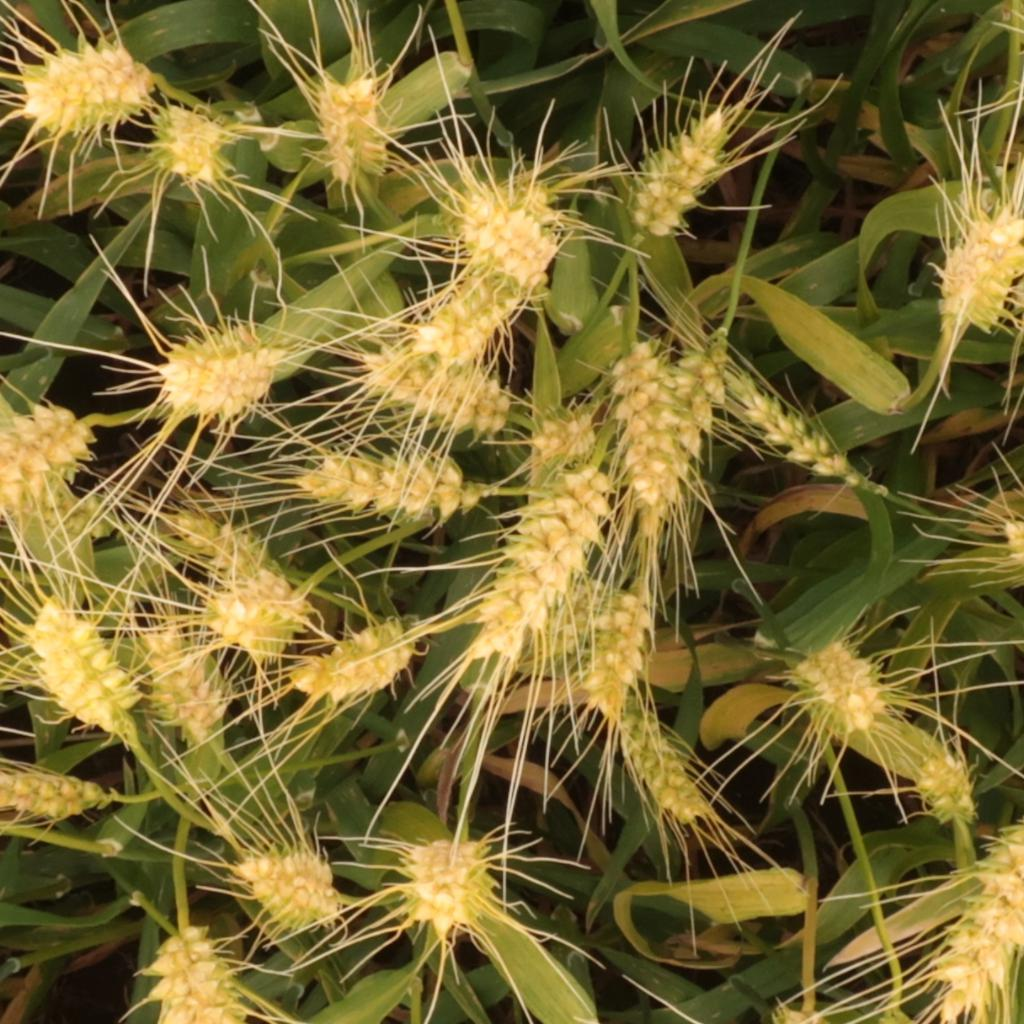

In [11]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Colab Notebooks/test/53f253011.jpg', width=600)

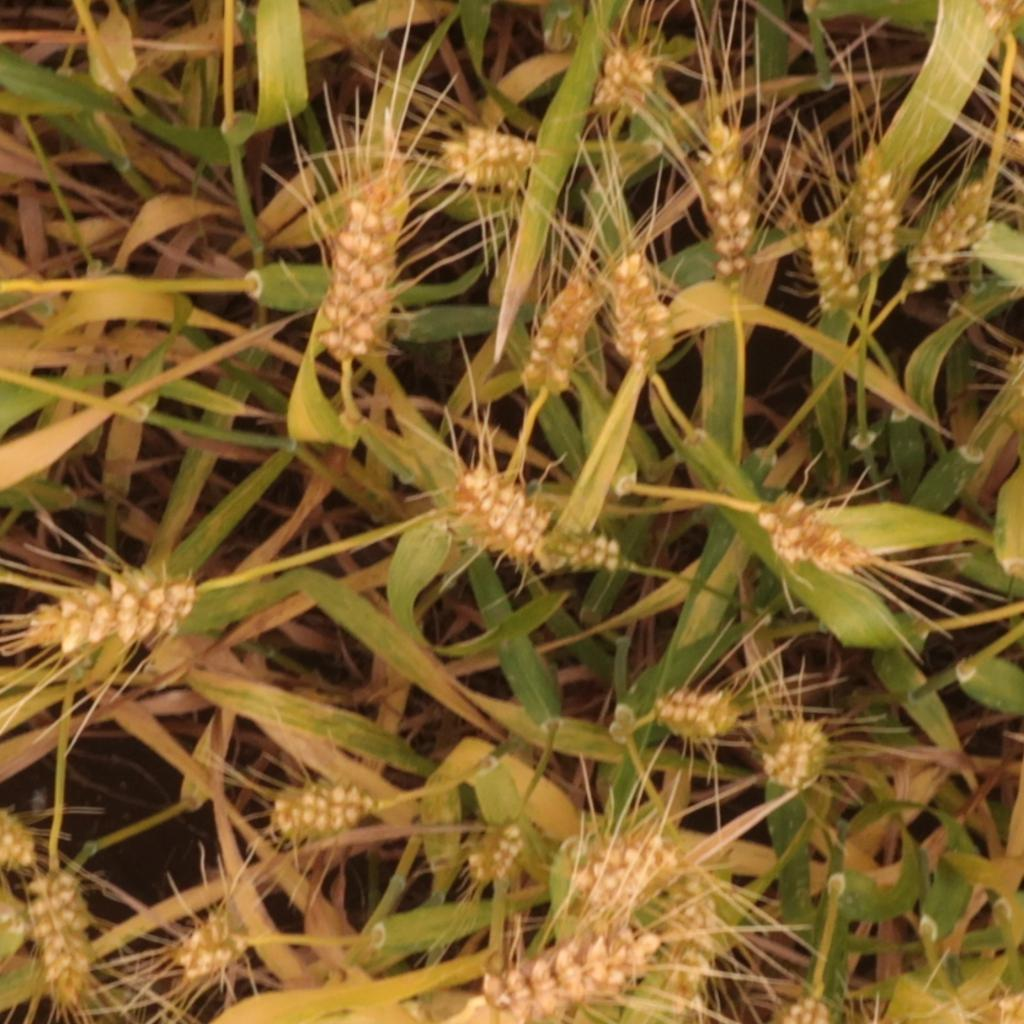

In [12]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Colab Notebooks/test/cb8d261a3.jpg', width=600)

## **Train Model**

In [13]:
!python /content/yolov5/train.py --img 1024 --batch 2 --epochs 10 \
                 --data /content/yolov5/wheat.yaml

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/yolov5/wheat.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=10, batch_size=2, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

### The final output indicates the location where the model was saved. In this case, at yolov5/runs/train/exp/weights/best.pt.

In [14]:
sh.rmtree("/content/drive/MyDrive/Colab Notebooks/dataset")

## **Test Model**

In [15]:
!python /content/yolov5/detect.py --source '/content/drive/MyDrive/Colab Notebooks/test' --weight '/content/yolov5/runs/train/exp/weights/best.pt'

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Colab Notebooks/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /content/drive/MyDrive/Colab Notebooks/test/2fd875eaa.jpg: 640x640 30 wheats, Done. (0.034s)
image 2/10 /content/drive/MyDrive/Colab Notebooks/test/348a992bb.jpg: 640x640 38 wheats, Done. (0.034s)
image 3/10 /content/drive/MyDrive/Colab Notebooks/test/51b3e36ab.jpg: 640x640 25 wheats, Done. (0.034s)
image 4/

## **Display Output Images**

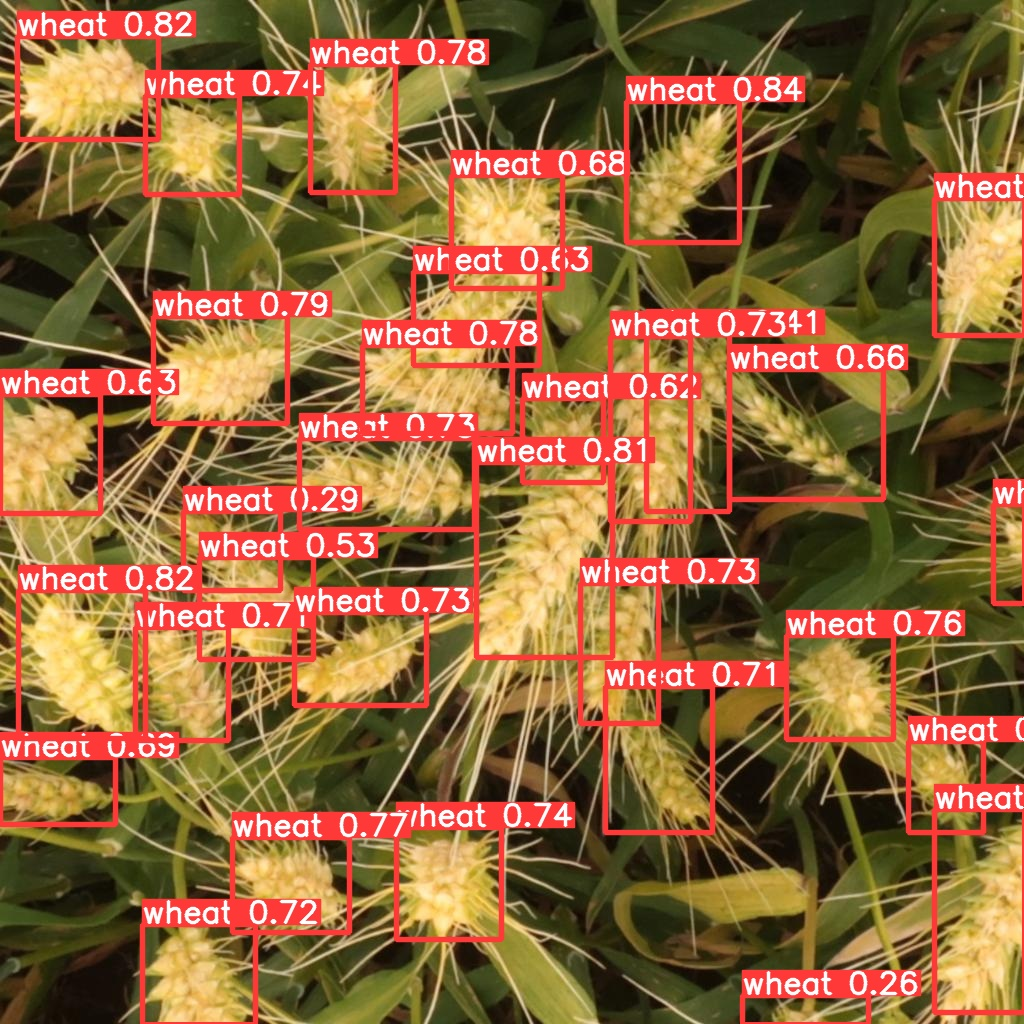

In [17]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/53f253011.jpg', width=600)

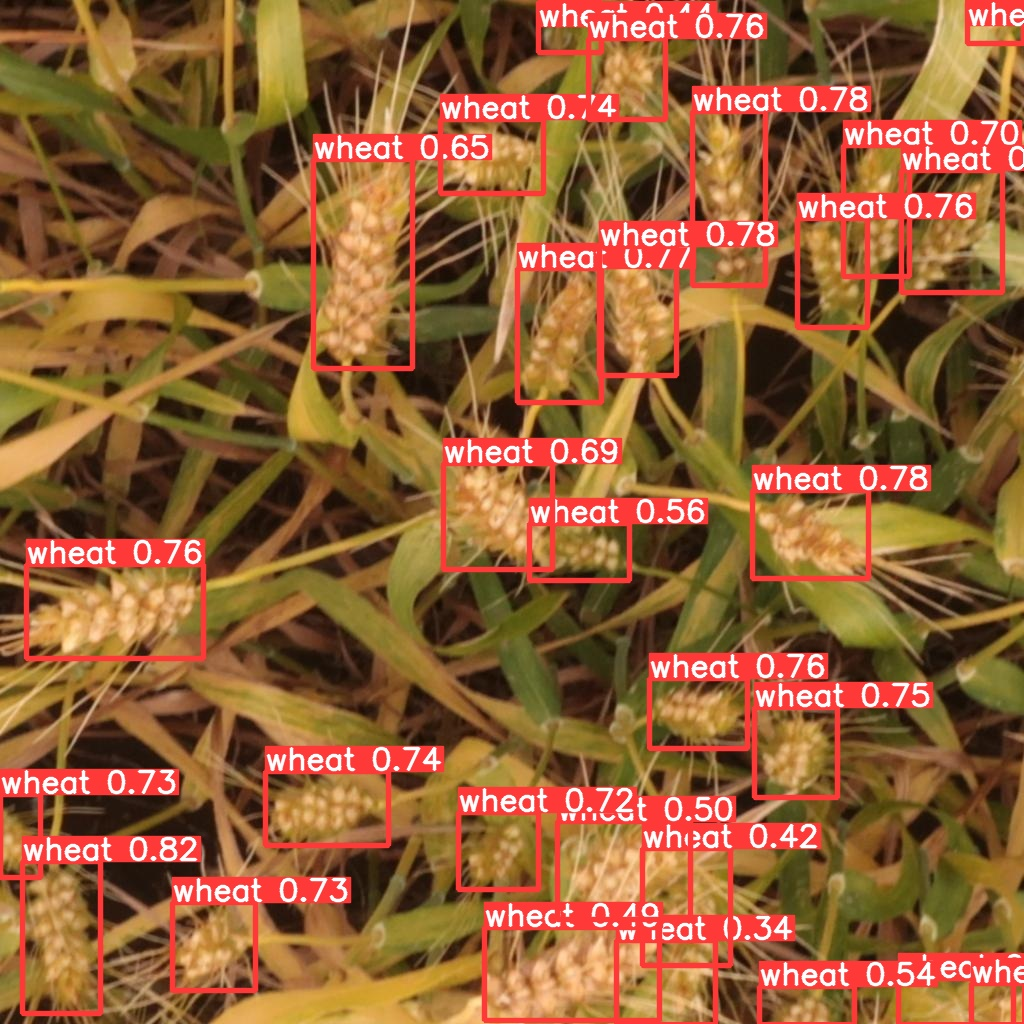

In [18]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/cb8d261a3.jpg', width=600)